In [1]:
#Add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

# Lesions to use

We must define the bbox of the lesions to detect using the DBT model framework.

In [2]:
from utils import dataset_CDD_CESM, patient_CDD

Key works to remove:
- Non enhancement
    - Nov visible lesion, not including
- Focus enhancement
    - There are regions with very weak enhancement, should we include them? E.g.: Pat18
- Rim enhancement
    - Should we include them? They have an inverse intensity to usual lesions (black instead of white)

Problems:
- Images with multiple lesions, which one to pick?
    - All?
    - Largest?
    - Accept satelite lesions?
- Irregular shapes, speculated masses, etc.
    - shoudl the Bbox include the whole annotated area?

- Ill defined lesions:
    - Redifine the annotation. Possible largest bbox?



In [102]:
mode = 'substracted'
dataset_CESM = dataset_CDD_CESM(mode=mode)
print(dataset_CESM)

excluding_list = ['non enhancement', 'focus enhancement', 'rim enhancement']

# exclude cases with 'non mass' tags
meta_filterd = dataset_CESM.metadata[~dataset_CESM.metadata['Tags'].str.contains('non mass', case=False)]
for case in excluding_list:
    meta_filterd = meta_filterd[~meta_filterd['Findings'].str.contains(case, case=False)]

# filter to keep only casses with word 'mass' in the tags
meta_filterd = meta_filterd[meta_filterd['Tags'].str.contains('mass')]
print(meta_filterd['Pathology Classification/ Follow up'].value_counts().to_string())
mass_patients = meta_filterd['Patient_ID'].unique()
print(f'Number of patients with mass: {len(mass_patients)}')
dataset_CESM.redefine_metadata(meta_filterd)

CDD-CESM dataset with 326 patients
Total images: 1003
Pathology Classification/ Follow up
Malignant    204
Benign        41
Number of patients with mass: 132


In [99]:
pat_id = dataset_CESM.patient_ids[15]
patient = patient_CDD(pat_id, dataset_CESM)
print(patient)


Patient 65 with 2 images


Image 1 of 2


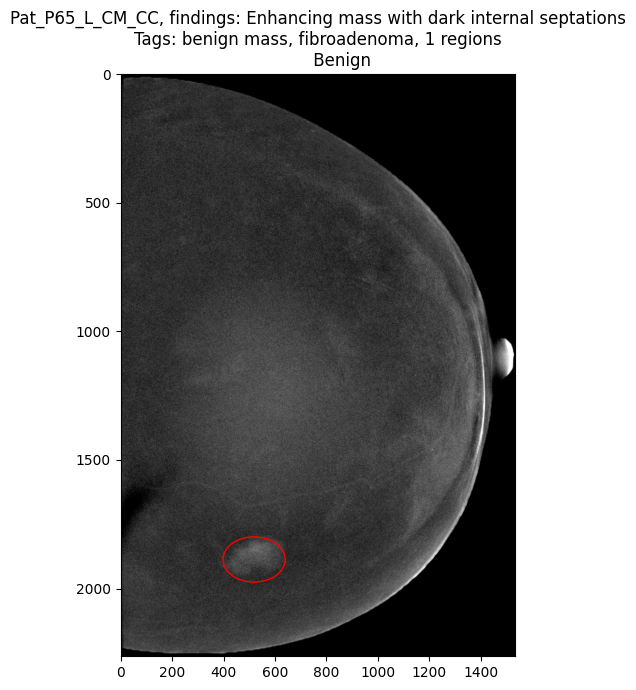

In [100]:
patient.set_image()
im_array = patient.get_array(plot=False)
patient.plot_annotations()

# Obtain bounding boxes of lesions

In [103]:
mode = 'substracted'
dataset_CESM = dataset_CDD_CESM(mode=mode)
print(dataset_CESM)

excluding_list = ['non enhancement', 'focus enhancement', 'rim enhancement']

# exclude cases with 'non mass' tags
meta_filterd = dataset_CESM.metadata[~dataset_CESM.metadata['Tags'].str.contains('non mass', case=False)]
for case in excluding_list:
    meta_filterd = meta_filterd[~meta_filterd['Findings'].str.contains(case, case=False)]

# filter to keep only casses with word 'mass' in the tags
meta_filterd = meta_filterd[meta_filterd['Tags'].str.contains('mass')]
print(meta_filterd['Pathology Classification/ Follow up'].value_counts().to_string())
mass_patients = meta_filterd['Patient_ID'].unique()
print(f'Number of patients with mass: {len(mass_patients)}')
dataset_CESM.redefine_metadata(meta_filterd)

CDD-CESM dataset with 326 patients
Total images: 1003
Pathology Classification/ Follow up
Malignant    204
Benign        41
Number of patients with mass: 132


In [137]:
from matplotlib.patches import Ellipse
import numpy as np
import matplotlib.pyplot as plt

In [143]:
def generate_ellipse_mask(image_shape:tuple, center_xy:tuple, axes:tuple):
    """generates a binary mask of an ellipse, given the original image dimensions and the ellipse parameters

    Args:
        image_shape (tuple): (height, width) of the original image
        center_xy (tuple): (center_x, center_y) of the ellipse
        axes (tuple): (a, b) main and minor axes of the ellipse

    Returns:
        np.array: binary 0,255 numpy array
    """
    height, width = image_shape[:2]
    center_x, center_y = center_xy
    a, b = axes
    y, x = np.ogrid[:height, :width]
    ellipse_mask = (((x - center_x) / a) ** 2 + ((y - center_y) / b) ** 2) <= 1
    return ellipse_mask.astype(np.uint8) * 255

Patient 2 with 2 images
Image 1 of 2
The current image has 9 annotations
The annotation is a(n) ellipse


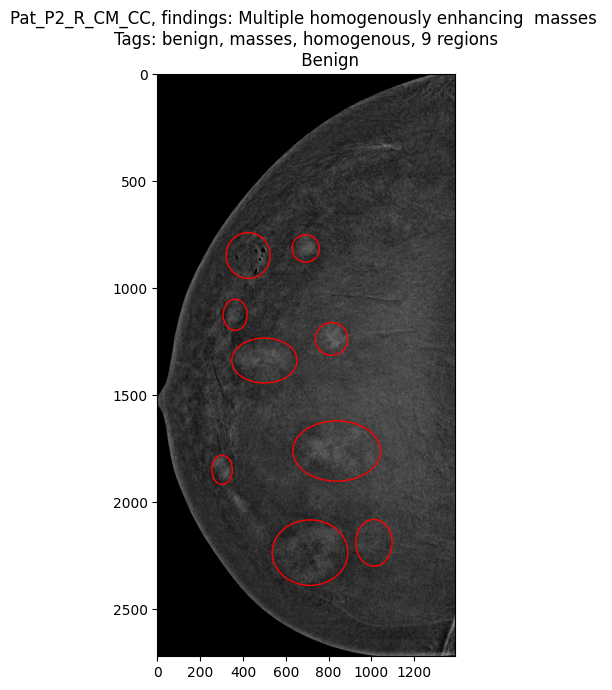

In [135]:
pat_id = dataset_CESM.patient_ids[0]
patient = patient_CDD(pat_id, dataset_CESM)
print(patient)
patient.set_image() # to load the image info
image = patient.get_array(flip=False, plot=False)
print(f'The current image has {patient.image_num_annotations} annotations')
# loop
region_num = range(patient.image_num_annotations)[0]

dic_ex = patient.image_annotations[patient.image_annotations.region_id==region_num].region_shape_attributes.values[0]
print(f'The annotation is a(n) {dic_ex["name"]}')
if dic_ex['name'] in ['ellipse','circle']:
    center, axes = patient.ellipse_reader(dic_ex)
    # draw the ellipse in an empty image with the size of the orignal image
    
elif dic_ex['name']=='polygon':
    vertices = patient.polygon_reader(dic_ex)
elif dic_ex['name']=='point':
    center = patient.point_reader(dic_ex)
patient.plot_annotations()

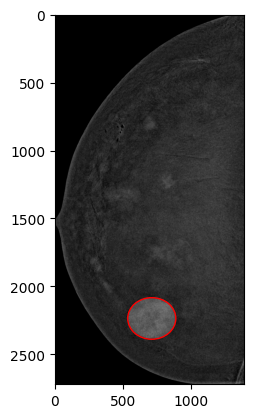

In [144]:
ellipse = generate_ellipse_mask(image.shape, center, axes)
# show the mask
fig, ax = plt.subplots()
ax.imshow(ellipse, cmap='gray')
ax.imshow(image, cmap='gray', alpha=0.8)
ax.add_patch(Ellipse(center, 2*axes[0], 2*axes[1], fill=False, edgecolor='r'))


In [7]:
from PIL import Image
from tqdm import tqdm

from torchvision.transforms import (
    Compose,
    Resize,
    CenterCrop,
)



resolution = 512

preprocess = Compose(
    [ # classic squared aspect-preserved centered image
        Resize(resolution),
        CenterCrop(resolution), 
    ]
)

In [19]:
# origin dir
low_energy_dir = repo_path / 'data/CDD-CESM/images/low-energy'
substracted_dir = repo_path / 'data/CDD-CESM/images/substracted' 

training_low = repo_path / 'data/CCDforBBDM/train/A'
training_sub = repo_path / 'data/CCDforBBDM/train/B'
training_low.mkdir(parents=True, exist_ok=True)
training_sub.mkdir(parents=True, exist_ok=True)

In [21]:
dataset = dataset_CDD_CESM()
pat_id = dataset.patient_ids[1]
patient = patient_CDD(pat_id, dataset)
patient

Patient 2 with 8 images

In [29]:
patient_ids = dataset.patient_ids
# make 80% of the patients the training set
training_patients = patient_ids[:int(len(patient_ids)*0.8)]
# the rest is the validation set
validation_patients = patient_ids[int(len(patient_ids)*0.8):]
print(f'Training set has {len(training_patients)} patients and validation set has {len(validation_patients)} patients')
print(f'The ratio of training is {len(training_patients)/len(patient_ids)}')
# check if the split have any repeated patients
print(f'Are there any repeated patients? {len(set(training_patients).intersection(set(validation_patients)))}')
print(f'Total number of patients: {len(patient_ids)}')
print(f'Total number of patients in the split: {len(training_patients)+len(validation_patients)}')

Training set has 260 patients and validation set has 66 patients
The ratio of training is 0.7975460122699386
Are there any repeated patients? 0
Total number of patients: 326
Total number of patients in the split: 326


In [22]:
while True:
    patient.set_image(show_status=False)
    im_path = patient.get_path()
    img = Image.open(im_path)
    img = preprocess(img)
    if 'low-energy' in str(im_path):
        dst_dir = training_low
    elif 'substracted' in str(im_path):
        dst_dir = training_sub
    img.save(dst_dir / im_path.name)
    
    if patient.row_counter==-1:
        break